# Bank-Marketing Benchmark

You can check the source here: https://www.kaggle.com/datasets/henriqueyamahata/bank-marketing

The data is related with direct marketing campaigns (phone calls) of a Portuguese banking institution. The classification goal is to predict if the client will subscribe a term deposit. The purpose of this project is to discover the machine learning model that best fits the data for benchmark purposes. The trained models are naive bayes, decision trees, random forest, xgboost, k-nearest neightbors, logistic regression, support vector machine and artificial neural network.

In [1]:
# Import libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score, KFold
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report
from xgboost import XGBClassifier
from yellowbrick.classifier import ConfusionMatrix
from scipy.stats import f_oneway, jarque_bera
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [2]:
# Get rid of annoying warnings

warnings.filterwarnings('ignore')

In [3]:
# Load dataset

pre_df = pd.read_csv('../src/bank-additional-full.csv', sep=';')
pre_df

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,retired,married,professional.course,no,yes,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes
41184,46,blue-collar,married,professional.course,no,no,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41185,56,retired,married,university.degree,no,yes,no,cellular,nov,fri,...,2,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41186,44,technician,married,professional.course,no,no,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes


In [4]:
# Check data info

pre_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

In [5]:
# Arrange dataframe

df = pd.concat([pre_df.iloc[:, :8], pre_df.iloc[:, -6:]], axis=1)
df['duration'] = pre_df['duration']
df.rename(columns={'y': 'deposit'}, inplace=True)
df.head()

,age,job,marital,education,default,housing,loan,contact,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,deposit,duration
0,56,housemaid,married,basic.4y,no,no,no,telephone,1.1,93.994,-36.4,4.857,5191.0,no,261
1,57,services,married,high.school,unknown,no,no,telephone,1.1,93.994,-36.4,4.857,5191.0,no,149
2,37,services,married,high.school,no,yes,no,telephone,1.1,93.994,-36.4,4.857,5191.0,no,226
3,40,admin.,married,basic.6y,no,no,no,telephone,1.1,93.994,-36.4,4.857,5191.0,no,151
4,56,services,married,high.school,no,no,yes,telephone,1.1,93.994,-36.4,4.857,5191.0,no,307


Month, day\_of\_week, campaign, pdays, previous and poutcome variables are removed in the dataframe due to lack of relevance. although duration should be discarded to obtain more realistic models, the focus is on extracting the best possible performance, so it's maintained.

In [6]:
# Data analysis (numeric variables)

df.describe()

,age,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,duration
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,0.081886,93.575664,-40.502600,3.621291,5167.035911,258.285010
std,10.42125,1.570960,0.578840,4.628198,1.734447,72.251528,259.279249
min,17.00000,-3.400000,92.201000,-50.800000,0.634000,4963.600000,0.000000
25%,32.00000,-1.800000,93.075000,-42.700000,1.344000,5099.100000,102.000000
50%,38.00000,1.100000,93.749000,-41.800000,4.857000,5191.000000,180.000000
75%,47.00000,1.400000,93.994000,-36.400000,4.961000,5228.100000,319.000000
max,98.00000,1.400000,94.767000,-26.900000,5.045000,5228.100000,4918.000000


In [7]:
# Check deposit values

df['deposit'].value_counts()

no     36548
yes     4640
Name: deposit, dtype: int64

There is data imbalance problem in the output variable. To correct the unbalanced data, the subsampling technique is used. The majority data is reduced until it reaches the same amount as the minority data. Removal of excess data
is done randomly.

### Subsampling Technique

In [8]:
# Resampling

majority_class = np.array(df[df['deposit'] == 'no'].index.tolist())
minority_class = np.array(df[df['deposit'] == 'yes'].index.tolist())

np.random.seed(0)
undersample = np.random.choice(majority_class, size=len(minority_class), replace=False)
resample = np.concatenate((minority_class, undersample))

df = df.loc[resample].sample(frac=1, replace=False).reset_index(drop=True)
df.head(10)

,age,job,marital,education,default,housing,loan,contact,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,deposit,duration
0,24,blue-collar,single,basic.9y,no,no,no,telephone,1.1,93.994,-36.4,4.857,5191.0,no,282
1,32,self-employed,single,university.degree,no,yes,no,cellular,-3.0,92.713,-33.0,0.706,5023.5,yes,205
2,51,technician,married,professional.course,no,yes,no,cellular,1.4,93.444,-36.1,4.968,5228.1,no,291
3,36,self-employed,married,university.degree,no,yes,no,cellular,-1.8,92.893,-46.2,1.264,5099.1,yes,414
4,43,services,married,professional.course,no,yes,no,cellular,1.4,93.918,-42.7,4.960,5228.1,no,451
5,38,admin.,married,university.degree,no,no,no,cellular,1.4,93.444,-36.1,4.963,5228.1,no,177
6,32,admin.,single,university.degree,no,yes,no,cellular,-2.9,92.469,-33.6,1.029,5076.2,yes,210
7,28,admin.,single,university.degree,no,no,no,cellular,-2.9,92.201,-31.4,0.879,5076.2,no,202
8,66,admin.,married,university.degree,no,no,no,cellular,-3.4,92.379,-29.8,0.770,5017.5,no,39
9,42,admin.,divorced,high.school,no,yes,no,telephone,1.1,93.994,-36.4,4.860,5191.0,no,119


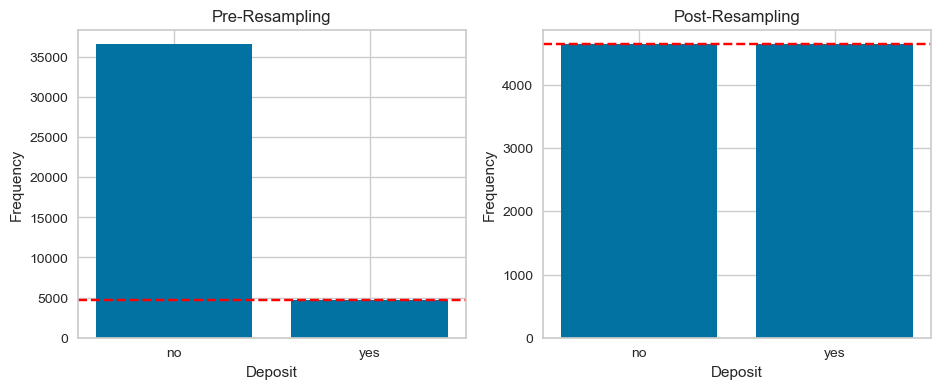

In [9]:
# Show resampling process

fig, axes = plt.subplots(1, 2, figsize=(11,4))

deposit_yes_amount = (pre_df['y'] == 'yes').sum()

axes[0].bar(x=pre_df['y'].unique(), height=pre_df['y'].value_counts())
axes[0].set_title('Pre-Resampling')
axes[0].set_xlabel('Deposit')
axes[0].set_ylabel('Frequency')
axes[0].axhline(y=deposit_yes_amount, color='red', linestyle='--')

axes[1].bar(x=pre_df['y'].unique(), height=df['deposit'].value_counts())
axes[1].set_title('Post-Resampling')
axes[1].set_xlabel('Deposit')
axes[1].set_ylabel('Frequency')
axes[1].axhline(y=deposit_yes_amount, color='red', linestyle='--')

plt.show()

There is now the same proportion of data for yes and no. Although it considerably reduces the amount of data available, the models will be able to obtain better results due to the balancing of the output variable.

### Multicollinearity analysis

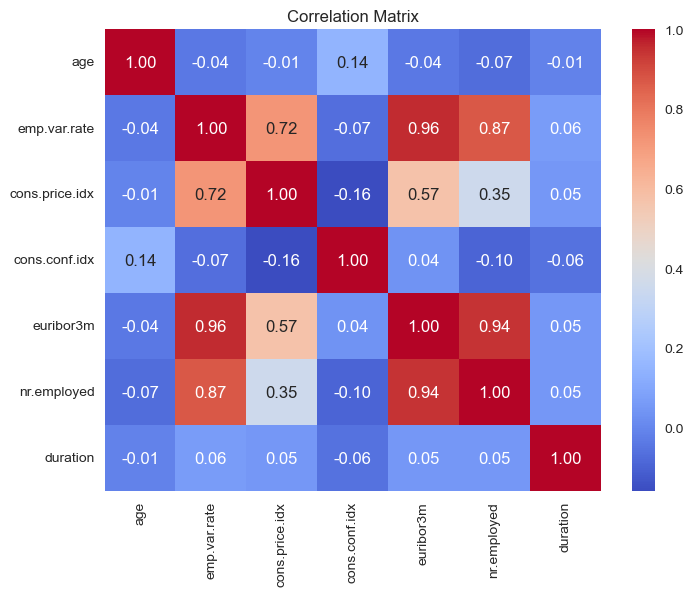

In [10]:
# Correlation matrix

plt.figure(figsize=(8, 6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

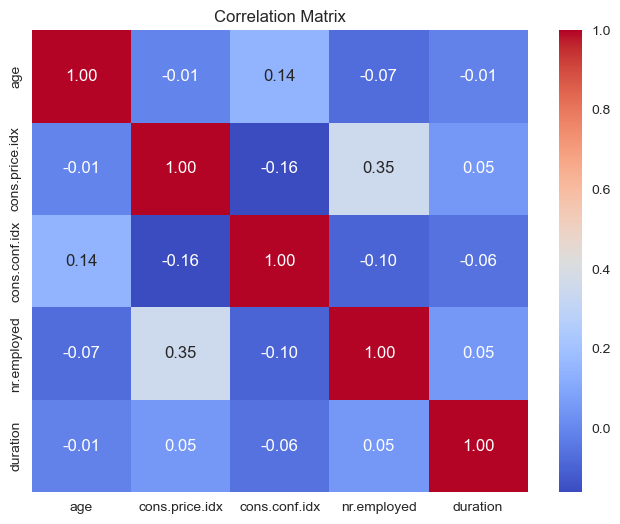

In [11]:
# Correlation matrix after fixing collinearity between variables

df = df.drop(['emp.var.rate', 'euribor3m'], axis=1)

plt.figure(figsize=(8, 6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

Note that removing the variables emp.var.rate and euribor3m corrects the strong
correlation between the variables without the need to also remove cons.price.idx and
nr.employed.

### Data Transformation

In [12]:
### Encoder ###

# Standard scaler

scaler_list = ['age', 'duration', 'cons.price.idx', 'cons.conf.idx', 'nr.employed']

for column in scaler_list:
    scaler = StandardScaler()
    df[column] = scaler.fit_transform(df[column].values.reshape(-1,1))

# Label encoder

label_list = ['contact', 'deposit']

for column in label_list:
    label_encoder = LabelEncoder()
    df[column] = label_encoder.fit_transform(df[column].values.ravel())


# One hot encoder

encode_list = ['job', 'marital', 'education', 'default', 'housing', 'loan']
one_hot_encoder = OneHotEncoder(sparse=False)

for column in encode_list:
    encoded_columns = one_hot_encoder.fit_transform(df[column].values.reshape(-1,1))
    encoded_df = pd.DataFrame(encoded_columns, columns=one_hot_encoder.get_feature_names_out([column]))
    df = pd.concat([df.drop(columns=[column]), encoded_df], axis=1)
    
df.head()

,age,contact,cons.price.idx,cons.conf.idx,nr.employed,deposit,duration,job_admin.,job_blue-collar,job_entrepreneur,...,education_university.degree,education_unknown,default_no,default_unknown,housing_no,housing_unknown,housing_yes,loan_no,loan_unknown,loan_yes
0,-1.371508,1,0.811523,0.707136,0.640035,0,-0.286681,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1,-0.701718,0,-1.210558,1.342659,-1.285155,1,-0.499719,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
2,0.889032,0,-0.056661,0.763212,1.066451,0,-0.261780,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
3,-0.366824,0,-0.926425,-1.124665,-0.416233,1,0.078527,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
4,0.219242,0,0.691556,-0.470450,1.066451,0,0.180896,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0


## Training Models

In [13]:
# Training and resampling data

mean_models = []

X = df.drop('deposit', axis=1)
y = df['deposit']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

### Naive Bayes

In [14]:
# Naive Bayes (model)

nb_model = GaussianNB()
nb_model.fit(X_train.values, y_train.values)

nb_predictions = nb_model.predict(X_test.values)

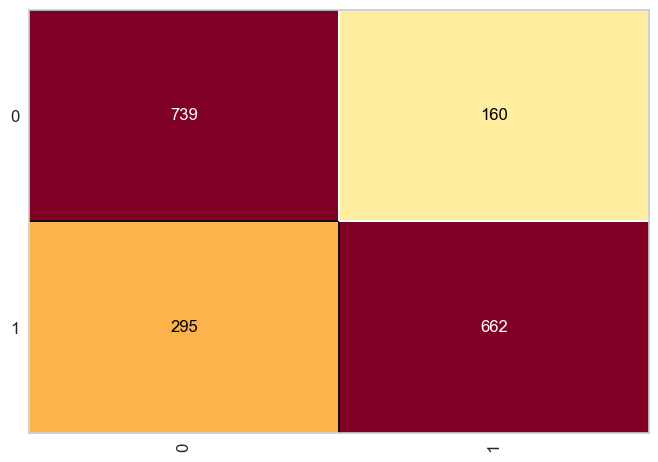

In [15]:
# Naive Bayes (confusion matrix)

nb_confusion_matrix = ConfusionMatrix(nb_model, classes=nb_model.classes_)
nb_confusion_matrix.fit(X_train.values, y_train.values)
nb_confusion_matrix.score(X_test.values, y_test.values)
mean_models.append(nb_confusion_matrix.score_)

In [16]:
# Naive Bayes (classification report)

print(classification_report(y_test, nb_predictions))

              precision    recall  f1-score   support

           0       0.71      0.82      0.76       899
           1       0.81      0.69      0.74       957

    accuracy                           0.75      1856
   macro avg       0.76      0.76      0.75      1856
weighted avg       0.76      0.75      0.75      1856



### Decision Trees

In [17]:
# Decision trees (grid search)

dt_params = {'criterion': ['gini', 'entropy'],
             'splitter': ['best', 'random'],
             'min_samples_split': [2, 5, 10],
             'min_samples_leaf': [1, 5, 10]}

dt_gridsearch = GridSearchCV(estimator=DecisionTreeClassifier(), param_grid=dt_params)
dt_gridsearch.fit(X_train.values, y_train.values)
print(f'''Best params: {dt_gridsearch.best_params_}
Best score: {dt_gridsearch.best_score_}''')

Best params: {'criterion': 'gini', 'min_samples_leaf': 10, 'min_samples_split': 5, 'splitter': 'random'}
Best score: 0.8651673064880612


In [18]:
# Decision trees (model)

dt_model = DecisionTreeClassifier(criterion='gini', min_samples_leaf=10, min_samples_split=5, splitter='random')
dt_model.fit(X_train.values, y_train.values)

dt_predictions = dt_model.predict(X_test.values)

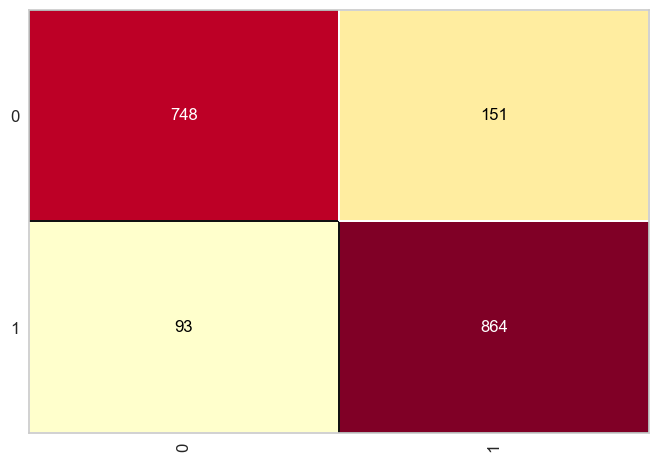

In [19]:
# Decision trees (confusion matrix)

dt_confusion_matrix = ConfusionMatrix(dt_model, classes=dt_model.classes_)
dt_confusion_matrix.fit(X_train.values, y_train.values)
dt_confusion_matrix.score(X_test.values, y_test.values)
mean_models.append(dt_confusion_matrix.score_)

In [20]:
# Decision trees (classification report)

print(classification_report(y_test, dt_predictions))

              precision    recall  f1-score   support

           0       0.89      0.83      0.86       899
           1       0.85      0.90      0.88       957

    accuracy                           0.87      1856
   macro avg       0.87      0.87      0.87      1856
weighted avg       0.87      0.87      0.87      1856



### Random Forest

In [21]:
# Random Forest (grid search)

rf_params = {'criterion': ['gini', 'entropy'],
             'n_estimators': [10, 25, 50, 100],
             'min_samples_split': [2, 5, 10],
             'min_samples_leaf': [1, 5, 10]}

rf_gridsearch = GridSearchCV(estimator=RandomForestClassifier(), param_grid=rf_params)
rf_gridsearch.fit(X_train.values, y_train.values)
print(f'''Best params: {rf_gridsearch.best_params_}
Best score: {rf_gridsearch.best_score_}''')

Best params: {'criterion': 'gini', 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 100}
Best score: 0.8834859829199452


In [22]:
# Random Forest

rf_model = RandomForestClassifier(criterion='gini', min_samples_leaf=5, min_samples_split=10, n_estimators=100)
rf_model.fit(X_train.values, y_train.values)

rf_predictions = rf_model.predict(X_test.values)

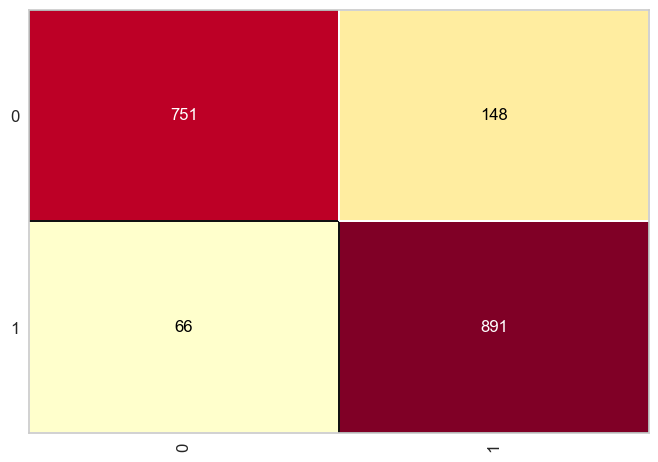

In [23]:
# Random Forest (confusion matrix)

rf_confusion_matrix = ConfusionMatrix(rf_model, classes=rf_model.classes_)
rf_confusion_matrix.fit(X_train.values, y_train.values)
rf_confusion_matrix.score(X_test.values, y_test.values)
mean_models.append(rf_confusion_matrix.score_)

In [24]:
# Random Forest (classification report)

print(classification_report(y_test, rf_predictions))

              precision    recall  f1-score   support

           0       0.92      0.84      0.88       899
           1       0.86      0.93      0.89       957

    accuracy                           0.88      1856
   macro avg       0.89      0.88      0.88      1856
weighted avg       0.89      0.88      0.88      1856



### XGBoost

In [25]:
# XGBoost (grid search)

xgb_params = {'max_depth': [2, 3, 5],
              'n_estimators': [10, 25, 50, 100],
              'gamma': [0.1, 0.2, 0.3]}

xgb_gridsearch = GridSearchCV(estimator=XGBClassifier(), param_grid=xgb_params)
xgb_gridsearch.fit(X_train.values, y_train.values)
print(f'''Best params: {xgb_gridsearch.best_params_}
Best score: {xgb_gridsearch.best_score_}''')

Best params: {'gamma': 0.3, 'max_depth': 5, 'n_estimators': 50}
Best score: 0.8842937914636029


In [26]:
# XGBoost (model)

xgb_model = XGBClassifier(gamma=0.3, max_depth=5, n_estimators=50)
xgb_model.fit(X_train.values, y_train.values)

xgb_predictions = xgb_model.predict(X_test.values)

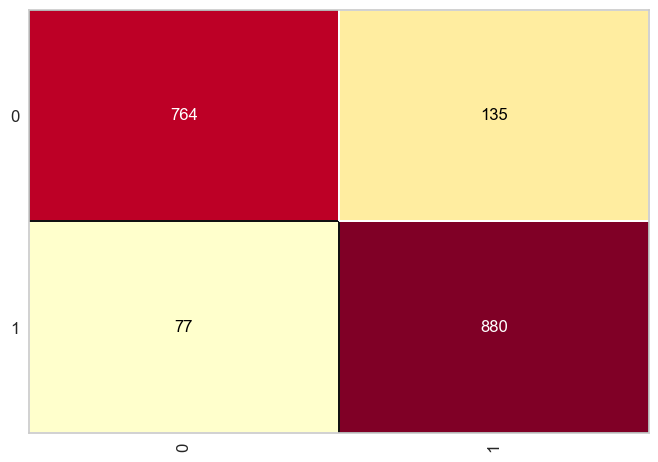

In [27]:
# XGBoost (confusion matrix)

xgb_confusion_matrix = ConfusionMatrix(xgb_model, classes=xgb_model.classes_)
xgb_confusion_matrix.fit(X_train.values, y_train.values)
xgb_confusion_matrix.score(X_test.values, y_test.values)
mean_models.append(xgb_confusion_matrix.score_)

In [28]:
# XGBoost (classification report)

print(classification_report(y_test, xgb_predictions))

              precision    recall  f1-score   support

           0       0.91      0.85      0.88       899
           1       0.87      0.92      0.89       957

    accuracy                           0.89      1856
   macro avg       0.89      0.88      0.89      1856
weighted avg       0.89      0.89      0.89      1856



### K-Nearest Nightbors

In [29]:
# K-Nearest Neighbors (grid search)

knn_params = {'n_neighbors': [3, 5, 10, 25],
             'p': [1, 2]}

knn_gridsearch = GridSearchCV(estimator=KNeighborsClassifier(), param_grid=knn_params)
knn_gridsearch.fit(X_train.values, y_train.values)
print(f'''Best params: {knn_gridsearch.best_params_}
Best score: {knn_gridsearch.best_score_}''')

Best params: {'n_neighbors': 25, 'p': 2}
Best score: 0.8410562044524308


In [30]:
# K-Nearest Neighbors (model)

knn_model = KNeighborsClassifier(n_neighbors=25, p=2)
knn_model.fit(X_train.values, y_train.values)

knn_predictions = knn_model.predict(X_test.values)

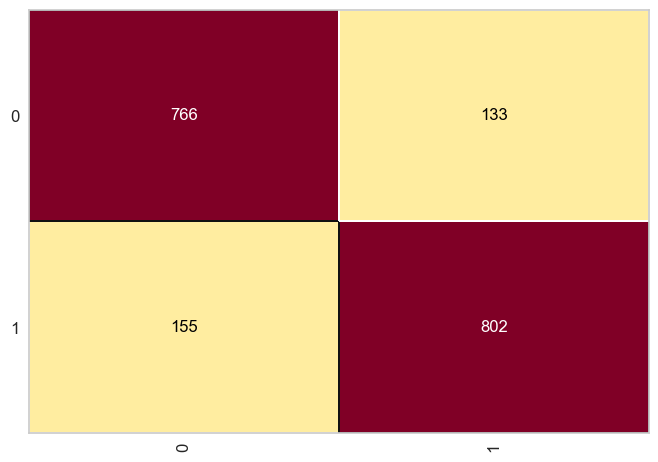

In [31]:
# Confusion matrix

knn_confusion_matrix = ConfusionMatrix(knn_model, classes=knn_model.classes_)
knn_confusion_matrix.fit(X_train.values, y_train.values)
knn_confusion_matrix.score(X_test.values, y_test.values)
mean_models.append(knn_confusion_matrix.score_)

In [32]:
# Classification report

print(classification_report(y_test, knn_predictions))

              precision    recall  f1-score   support

           0       0.83      0.85      0.84       899
           1       0.86      0.84      0.85       957

    accuracy                           0.84      1856
   macro avg       0.84      0.85      0.84      1856
weighted avg       0.85      0.84      0.84      1856



### Logistic Regression

In [33]:
# Logistic Regression (grid search)

lr_params = {'tol': [0.001, 0.0001, 0.00001],
             'C': [1.0, 1.5, 2.0],
             'solver': ['liblinear', 'newton-cg']}

lr_gridsearch = GridSearchCV(estimator=LogisticRegression(), param_grid=lr_params)
lr_gridsearch.fit(X_train.values, y_train.values)
print(f'''Best params: {lr_gridsearch.best_params_}
Best score: {lr_gridsearch.best_score_}''')

Best params: {'C': 1.5, 'solver': 'liblinear', 'tol': 0.001}
Best score: 0.8550640275168577


In [34]:
# Logistic Regression

lr_model = LogisticRegression(C=1.5, solver='liblinear', tol=0.001)
lr_model.fit(X_train.values, y_train.values)

lr_predictions = lr_model.predict(X_test.values)

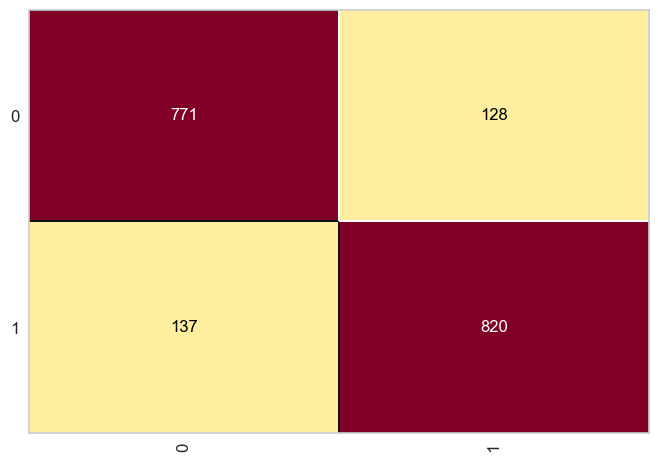

In [35]:
# Logistic Regression (confusion matrix)

lr_confusion_matrix = ConfusionMatrix(lr_model, classes=lr_model.classes_)
lr_confusion_matrix.fit(X_train.values, y_train.values)
lr_confusion_matrix.score(X_test.values, y_test.values)
mean_models.append(lr_confusion_matrix.score_)

In [36]:
# Logistic Regression (classification report)

print(classification_report(y_test, lr_predictions))

              precision    recall  f1-score   support

           0       0.85      0.86      0.85       899
           1       0.86      0.86      0.86       957

    accuracy                           0.86      1856
   macro avg       0.86      0.86      0.86      1856
weighted avg       0.86      0.86      0.86      1856



### Support Vector Machine

In [37]:
# Support Vector Machine (grid search)

svm_params = {'tol': [0.001, 0.0001, 0.00001],
              'C': [1.0, 1.5, 2.0],
              'kernel': ['rbf', 'linear', 'poly', 'sigmoid']}

svm_gridsearch = GridSearchCV(estimator=SVC(), param_grid=svm_params)
svm_gridsearch.fit(X_train.values, y_train.values)
print(f'''Best params: {svm_gridsearch.best_params_}
Best score: {svm_gridsearch.best_score_}''')

Best params: {'C': 2.0, 'kernel': 'rbf', 'tol': 0.001}
Best score: 0.8679957708259595


In [38]:
# Support Vector Machine (model)

svm_model = SVC(C=2.0, kernel='rbf', tol=0.001)
svm_model.fit(X_train.values, y_train.values)

svm_predictions = svm_model.predict(X_test.values)

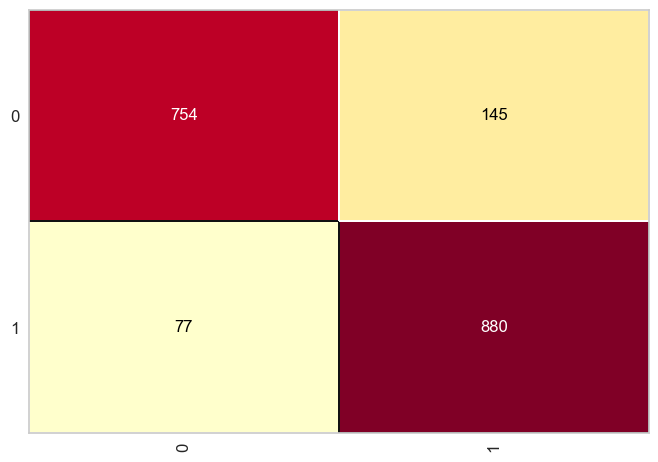

In [39]:
# Support Vector Machine (confusion matrix)

svm_confusion_matrix = ConfusionMatrix(svm_model, classes=svm_model.classes_)
svm_confusion_matrix.fit(X_train.values, y_train.values)
svm_confusion_matrix.score(X_test.values, y_test.values)
mean_models.append(svm_confusion_matrix.score_)

In [40]:
# Support Vector Machine (classification report)

print(classification_report(y_test, svm_predictions))

              precision    recall  f1-score   support

           0       0.91      0.84      0.87       899
           1       0.86      0.92      0.89       957

    accuracy                           0.88      1856
   macro avg       0.88      0.88      0.88      1856
weighted avg       0.88      0.88      0.88      1856



### Artificial Neural Network

In [41]:
# Artificial Neural Network (grid search)

ann_params = {'activation': ['relu', 'logistic', 'tanh'],
              'solver': ['adam', 'sgd'],
              'batch_size': [10, 25, 50]}

ann_gridsearch = GridSearchCV(estimator=MLPClassifier(), param_grid=ann_params)
ann_gridsearch.fit(X_train.values, y_train.values)
print(f'''Best params: {ann_gridsearch.best_params_}
Best score: {ann_gridsearch.best_score_}''')

Best params: {'activation': 'tanh', 'batch_size': 25, 'solver': 'sgd'}
Best score: 0.8673220071333277


In [42]:
# Artificial Neural Network (model)

ann_model = MLPClassifier(activation='tanh', batch_size=25, solver='sgd')
ann_model.fit(X_train.values, y_train.values)

ann_predictions = ann_model.predict(X_test.values)

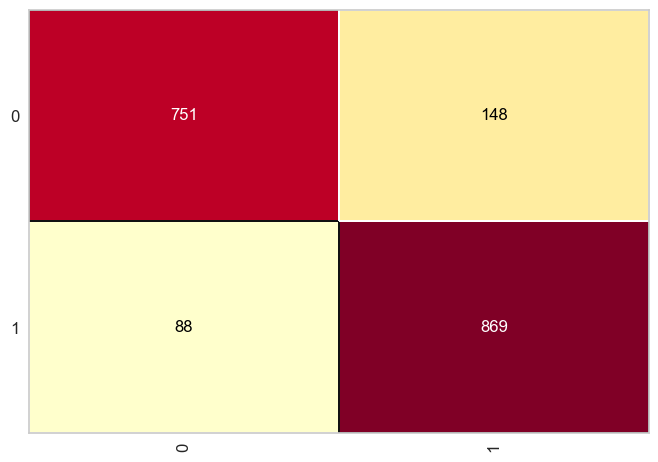

In [43]:
# Artificial Neural Network (confusion matrix)

ann_confusion_matrix = ConfusionMatrix(ann_model, classes=ann_model.classes_)
ann_confusion_matrix.fit(X_train.values, y_train.values)
ann_confusion_matrix.score(X_test.values, y_test.values)
mean_models.append(ann_confusion_matrix.score_)

In [44]:
# Artificial Neural Network (classification report)

print(classification_report(y_test, svm_predictions))

              precision    recall  f1-score   support

           0       0.91      0.84      0.87       899
           1       0.86      0.92      0.89       957

    accuracy                           0.88      1856
   macro avg       0.88      0.88      0.88      1856
weighted avg       0.88      0.88      0.88      1856



Analyzing the results, it is observed that random forest and xgboost models are the
best for prediction. The difference between them is almost insignificant. Cross-validation
should be performed to technically evaluate the best model.

## Cross Validation

In [45]:
### Cross validation ###

evaluation_models = []

pre_label_models = np.array(['Naive Bayes', 'Decision Trees', 'Random Forest', 'XGBoost',
                             'K-Nearest Neighbors', 'Logistic Regression', 'Support Vector Machine',
                             'Artificial Neural Network'])

label_models = list(np.array([[model] * 30 for model in pre_label_models]).reshape(1,-1).flatten())

model_list = [nb_model, dt_model, rf_model, xgb_model, knn_model, lr_model, svm_model, ann_model]

for i in range(len(label_models)):
    kfold = KFold(n_splits=5, shuffle=True, random_state=i%30)
    cv_results = cross_val_score(model_list[int(np.floor(i//30))], X, y, cv=kfold)
    evaluation_models.append(cv_results.mean())

cv_results = pd.DataFrame({'Naive Bayes': evaluation_models[:30], 'Decision Trees': evaluation_models[30:60],
                           'Random Forest': evaluation_models[60:90], 'XGBoost': evaluation_models[90:120],
                           'K-Nearest Neighbors': evaluation_models[120:150],
                           'Logistic Regression': evaluation_models[150:180],
                           'Support Vector Machine': evaluation_models[180:210],
                           'Artificial Neural Network': evaluation_models[210:]})
cv_results.head()

,Naive Bayes,Decision Trees,Random Forest,XGBoost,K-Nearest Neighbors,Logistic Regression,Support Vector Machine,Artificial Neural Network
0,0.767672,0.865086,0.883405,0.885884,0.845043,0.853879,0.871121,0.868103
1,0.767780,0.859914,0.882974,0.884052,0.842134,0.855172,0.871228,0.867134
2,0.766810,0.863578,0.881573,0.883836,0.843319,0.854741,0.870582,0.868750
3,0.767349,0.865302,0.882220,0.883082,0.842457,0.855172,0.870797,0.867241
4,0.767349,0.858944,0.880603,0.880711,0.839763,0.854310,0.869504,0.865625


In [46]:
# Describe

cv_results.describe()

,Naive Bayes,Decision Trees,Random Forest,XGBoost,K-Nearest Neighbors,Logistic Regression,Support Vector Machine,Artificial Neural Network
count,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000
mean,0.764644,0.863114,0.882504,0.882626,0.842992,0.855302,0.870697,0.867579
std,0.007479,0.002251,0.000881,0.001407,0.001532,0.000830,0.000833,0.001273
min,0.737069,0.858944,0.880603,0.880496,0.839763,0.853879,0.869181,0.865409
25%,0.765113,0.860830,0.881897,0.881546,0.841945,0.854849,0.870043,0.866810
50%,0.766487,0.863308,0.882597,0.882489,0.843103,0.855065,0.870690,0.867726
75%,0.767645,0.865059,0.882974,0.883432,0.844154,0.855900,0.871202,0.868400
max,0.769073,0.866810,0.884375,0.885884,0.846228,0.857004,0.872737,0.869828


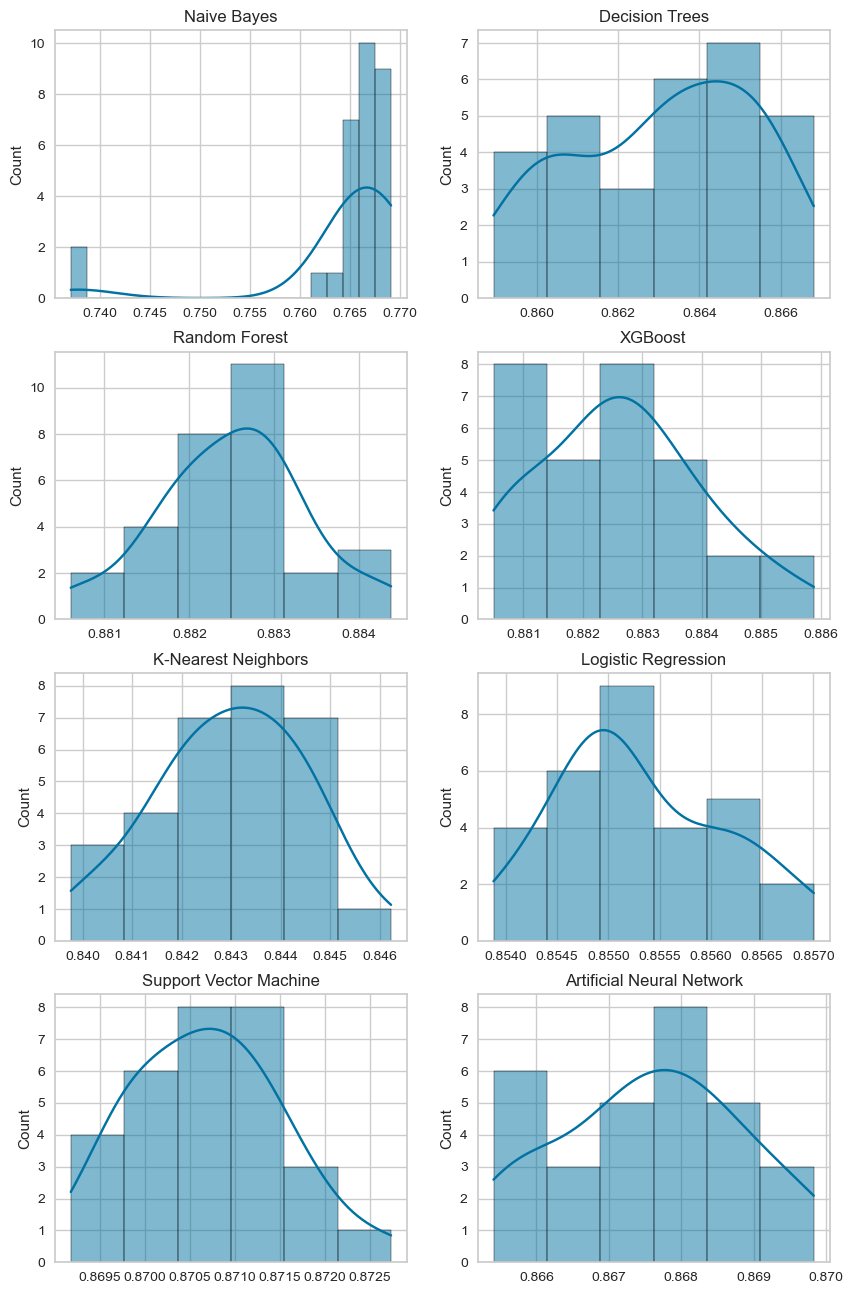

In [51]:
# histograms for normality analysis (machine learning)

fig, axes = plt.subplots(4, 2, figsize=(10, 16))

for i in range(len(pre_label_models)):
    sns.histplot(cv_results[pre_label_models[i]].values, kde=True, ax=axes[int(np.floor(i//2)), i%2])
    axes[int(np.floor(i//2)), i%2].set_title(pre_label_models[i])
    
plt.show()

In [53]:
# Jarque-Bera test

for i in range(len(pre_label_models)):
    jb_stat, jb_p = jarque_bera(evaluation_models[i*30:(i+1)*30])
    print(f"{pre_label_models[i]}: JB statistic: {jb_stat}, p-value: {jb_p}")

Naive Bayes: JB statistic: 152.15338389146, p-value: 0.0
Decision Trees: JB statistic: 2.035271990517782, p-value: 0.3614483967114557
Random Forest: JB statistic: 0.025402645885090547, p-value: 0.9873789984374726
XGBoost: JB statistic: 0.7826339396234933, p-value: 0.676165797922881
K-Nearest Neighbors: JB statistic: 0.36291641539497366, p-value: 0.8340531015746457
Logistic Regression: JB statistic: 1.3228591024451406, p-value: 0.5161129969060285
Support Vector Machine: JB statistic: 0.6648374137442575, p-value: 0.7171869688662265
Artificial Neural Network: JB statistic: 0.953261432653192, p-value: 0.62087176477038


The evaluation means follow a normal distribution with the exception of naive Bayes.

In [55]:
# ANOVA test

anova_f, anova_p = f_oneway(evaluation_models[:30], evaluation_models[30:60], evaluation_models[60:90],
                            evaluation_models[90:120], evaluation_models[120:150], evaluation_models[150:180],
                            evaluation_models[180:210], evaluation_models[210:])
print(f'''F statistic: {anova_f}
p-value: {anova_p}''')

F statistic: 5102.209737405676
p-value: 3.871879923036506e-250


There are significant differences between the comparison groups.

In [56]:
# Tukey's range test

tukey_results = pairwise_tukeyhsd(endog=evaluation_models, groups=label_models, alpha=0.05)

print(tukey_results)

                  Multiple Comparison of Means - Tukey HSD, FWER=0.05                  
          group1                  group2         meandiff p-adj   lower   upper  reject
---------------------------------------------------------------------------------------
Artificial Neural Network         Decision Trees  -0.0045    0.0 -0.0068 -0.0021   True
Artificial Neural Network    K-Nearest Neighbors  -0.0246    0.0 -0.0269 -0.0223   True
Artificial Neural Network    Logistic Regression  -0.0123    0.0 -0.0146   -0.01   True
Artificial Neural Network            Naive Bayes  -0.1029    0.0 -0.1053 -0.1006   True
Artificial Neural Network          Random Forest   0.0149    0.0  0.0126  0.0172   True
Artificial Neural Network Support Vector Machine   0.0031 0.0014  0.0008  0.0054   True
Artificial Neural Network                XGBoost    0.015    0.0  0.0127  0.0174   True
           Decision Trees    K-Nearest Neighbors  -0.0201    0.0 -0.0224 -0.0178   True
           Decision Trees    Log

Through the results of the Tukey test, there is no evidence of different means between random forest and xgboost models. This means that these models are statistically equal. This result is important because it's not always just about observing the model with the best accuracy. A more detailed assessment can reveal important information like this one.

In [59]:
# Results by model

mean_results = {}

for key, values in zip(pre_label_models, mean_models):
    mean_results[key] = values

print(mean_results)

{'Naive Bayes': 0.7548491379310345, 'Decision Trees': 0.8685344827586207, 'Random Forest': 0.884698275862069, 'XGBoost': 0.8857758620689655, 'K-Nearest Neighbors': 0.8448275862068966, 'Logistic Regression': 0.8572198275862069, 'Support Vector Machine': 0.8803879310344828, 'Artificial Neural Network': 0.8728448275862069}


In [60]:
# Results by evaluation

evaluation_results = {}

for i in range(len(pre_label_models)):
    key = pre_label_models[i]
    values = float(np.array(evaluation_models[i*30:(i+1)*30]).mean())
    evaluation_results[key] = values

print(evaluation_results)

{'Naive Bayes': 0.7646443965517242, 'Decision Trees': 0.8631142241379312, 'Random Forest': 0.8825035919540232, 'XGBoost': 0.8826257183908047, 'K-Nearest Neighbors': 0.8429920977011494, 'Logistic Regression': 0.8553017241379308, 'Support Vector Machine': 0.8706968390804595, 'Artificial Neural Network': 0.8675790229885058}


## Conclusion

The conclusion is that the best model will have to be based on decision making. If correctly predicting whether the customer will subscribe a deposit term (yes) is more important, the model chosen is random forest. Otherwise, the best model will be xgboost.